In [10]:
!pip install ../../repliclust

import repliclust as rpl

Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: '../../repliclust': Expected package name at the start of dependency specifier
    ../../repliclust
    ^
Hint: It looks like a path. File '../../repliclust' does not exist.


In [4]:
import pickle

archetypes = [
    rpl.Archetype.from_verbal_description(
        f"two clusters with very different shapes in {p}D"
    ) for p in [2, 10, 30, 100]
]

with open("./output/archetypes_overlap_control.pkl", "rb") as file:
    archetypes = pickle.load(file)

In [5]:
print(archetypes[0].describe())
print(archetypes[1].describe())
print(archetypes[2].describe())
print(archetypes[3].describe())

{'n_clusters': 2, 'dim': 2, 'n_samples': 200, 'scale': 1.0, 'name': 'two_very_different_shapes_2d', 'aspect_ref': 1.5, 'aspect_maxmin': 3.0, 'radius_maxmin': 3, 'imbalance_ratio': 2, 'max_overlap': 0.05, 'min_overlap': 0.001, 'packing': 0.1, 'learning_rate': 0.5, 'linear_penalty_weight': 0.01}
{'n_clusters': 2, 'dim': 10, 'n_samples': 200, 'scale': 1.0, 'name': 'two_very_different_shapes_10d', 'aspect_ref': 1.5, 'aspect_maxmin': 3.0, 'radius_maxmin': 3, 'imbalance_ratio': 2, 'max_overlap': 0.05, 'min_overlap': 0.001, 'packing': 0.1, 'learning_rate': 0.5, 'linear_penalty_weight': 0.01}
{'n_clusters': 2, 'dim': 30, 'n_samples': 200, 'scale': 1.0, 'name': 'two_very_different_shapes_30d', 'aspect_ref': 1.5, 'aspect_maxmin': 3.0, 'radius_maxmin': 3, 'imbalance_ratio': 2, 'max_overlap': 0.05, 'min_overlap': 0.001, 'packing': 0.1, 'learning_rate': 0.5, 'linear_penalty_weight': 0.01}
{'n_clusters': 2, 'dim': 100, 'n_samples': 200, 'scale': 1.0, 'name': 'two_very_different_shapes_100d', 'aspect

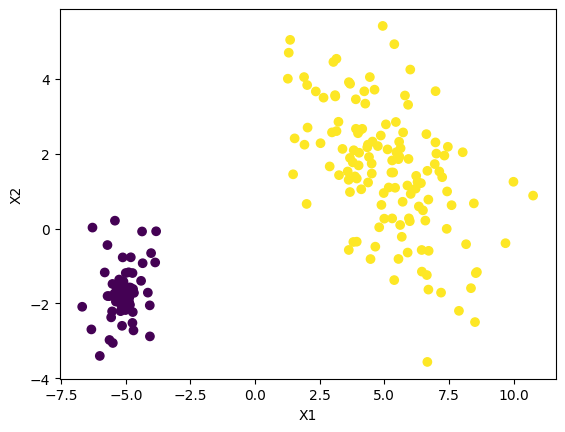

In [13]:
mo = 1e-7
arch = archetypes[0]
arch = arch.edit_params(max_overlap=mo, min_overlap=mo/10, overlap_mode="lda")
X, y, _ = arch.synthesize(quiet=True)
rpl.plot(X,y)

In [24]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score
from tqdm import tqdm

N_REPL = 100

MO_VALS = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0.25,0.5]

results = {}

for arch in tqdm(archetypes):
    mean_ami_list = []
    mean_arand_list = []
    mean_sil_list = []
    sd_ami_list = []
    sd_arand_list = []
    sd_sil_list = []

    for mo in MO_VALS:
        arch = arch.edit_params(max_overlap=mo, min_overlap=mo/10, overlap_mode="lda")
        
        ami_list = []
        arand_list = []
        sil_list = []
        for i in range(N_REPL):
            X, y ,_ = arch.synthesize(quiet=True)
            # X = rpl.distort(X)
            # y_hat = KMeans(n_clusters=arch.n_clusters, init='k-means++').fit_predict(X)
            y_hat = AgglomerativeClustering(n_clusters=arch.n_clusters).fit_predict(X)
            # y_hat = GaussianMixture(n_components=arch.n_clusters, init_params='k-means++').fit_predict(X)
            ami_list.append(adjusted_mutual_info_score(y, y_hat))
            arand_list.append(adjusted_rand_score(y, y_hat))
            sil_list.append(silhouette_score(X,y))

        mean_ami_list.append(np.mean(ami_list))
        mean_arand_list.append(np.mean(arand_list))
        mean_sil_list.append(np.mean(sil_list))
        sd_ami_list.append(np.std(ami_list))
        sd_arand_list.append(np.std(arand_list))
        sd_sil_list.append(np.std(sil_list))
    
    results[arch.name] = {
        "mean_ami": mean_ami_list,
        "mean_arand": mean_arand_list,
        "mean_sil": mean_sil_list,
        "sd_ami": sd_ami_list,
        "sd_arand": sd_arand_list,
        "sd_sil": sd_sil_list
    }

100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


/tmp/ipykernel_3099339/2989314327.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(MO_VALS, means, c=colors[i])


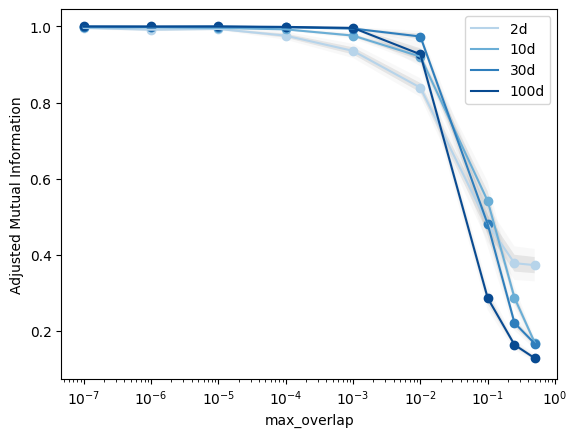

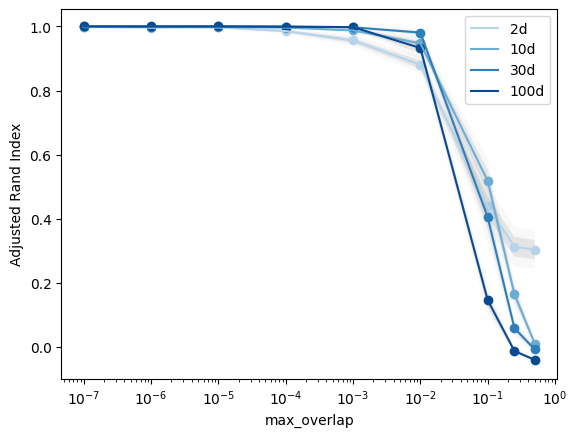

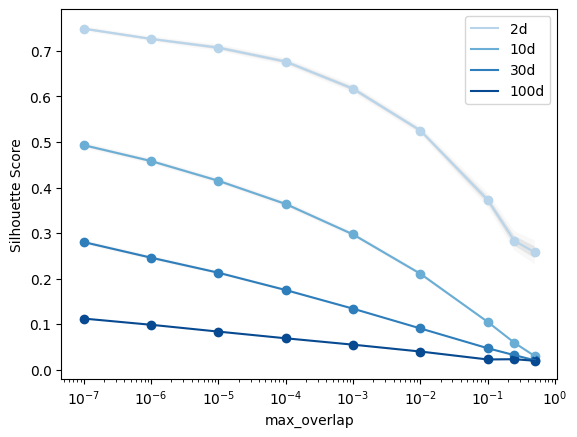

In [25]:
import matplotlib.pyplot as plt

pretty_names = {
    'ami': "Adjusted Mutual Information",
    'arand': "Adjusted Rand Index",
    'sil': "Silhouette Score"
}

for metric in ['ami', 'arand', 'sil']:
    plt.figure()
    cmap = plt.get_cmap('Blues')
    colors = [cmap(i) for i in np.linspace(0.3, 0.9, 4)]

    for i, (name, rslts) in enumerate(results.items()):
        means = np.array(rslts[f"mean_{metric}"])
        stds = np.array(rslts[f"sd_{metric}"])/np.sqrt(N_REPL)

        plt.fill_between(MO_VALS, means - stds, means + stds, color='gray', edgecolor=None, alpha=0.2)
        plt.fill_between(MO_VALS, means - 2*stds, means -stds, color='gray', edgecolor=None, alpha=0.05)
        plt.fill_between(MO_VALS, means + stds, means + 2*stds, color='gray', edgecolor=None, alpha=0.05)

        plt.scatter(MO_VALS, means, c=colors[i])
        plt.plot(MO_VALS, means, c=colors[i], label=name.split("_edited")[0].split("_")[-1])

    plt.gca().set_xscale('log')
    plt.legend()
    plt.xlabel("max_overlap")
    plt.ylabel(pretty_names[metric])